# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

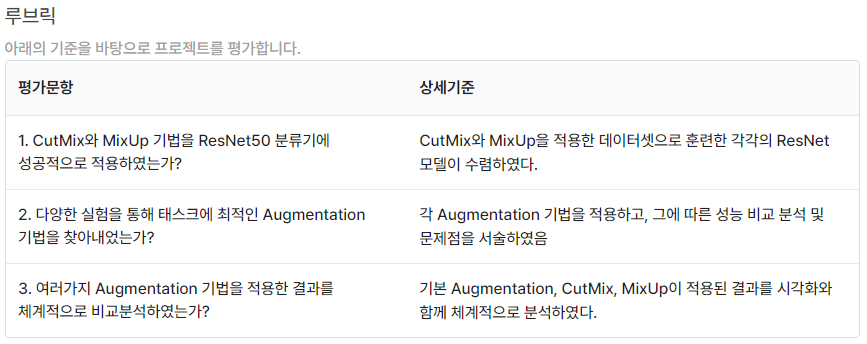

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.19.5


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Augmentation liblrary
import albumentations as A

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
print('=3')

=3


In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [7]:
ds_info.features["label"].num_classes

120

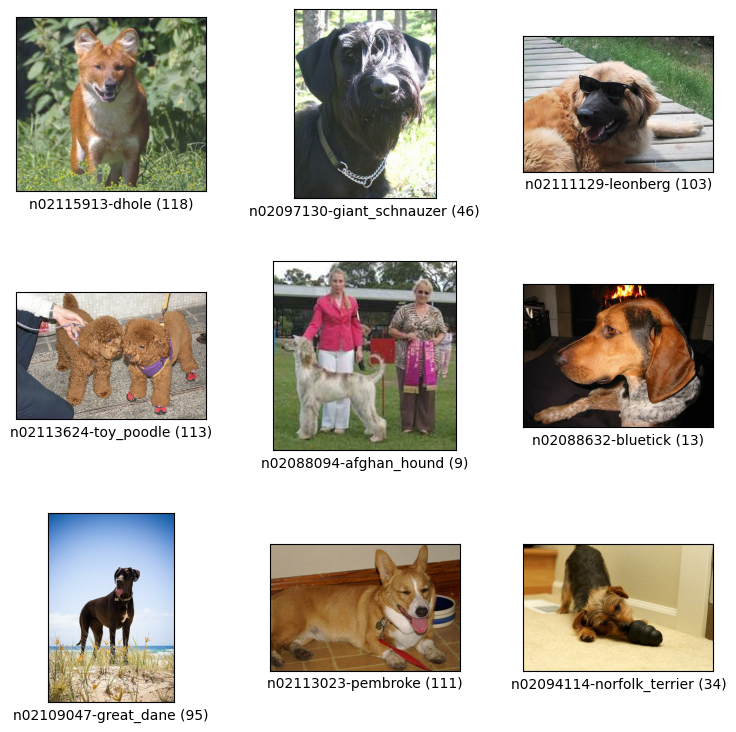

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

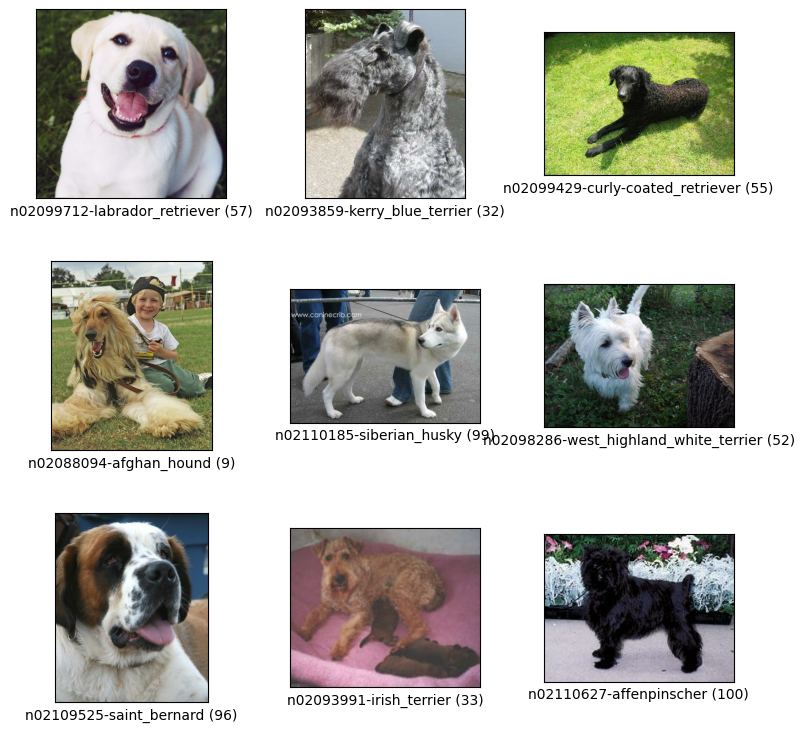

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

### 1. Augmentation을 적용한 데이터셋 만들기
----
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.


__Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?__

> CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

#### 1) 기본 전처리 및 오그멘테이션

In [10]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1) # random_brightness다음에 무조건 와야하는 코드, random brightness때문에 텐서의 값의 범위가 초과 할수 있다. 그 부분으로 해결해준다. 
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

print('=3')

=3


In [11]:
def augment2(image,label):
    image_arr = np.array(image)
    transform = A.Compose([
        A.Affine(rotate=(-45, 45),scale=(0.5,0.9),p=0.5) 
    ])
    transformed = transform(image=image_arr)
    t_image = transformed['image']
    image = tf.t_image.resize(t_image, [224, 224])
    return image, label

#### 2) Cutmix 및 Mixup 수행 함수

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [13]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [14]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [15]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [18]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [19]:
def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16, with_aug=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### 2. 모델 만들기
----
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

#### 1) 실험설계

데이터 augmentation의 성능을 테스트하기 위해 다음과 같은 데이터를 준비해서 각각 학습을 진행하여 그 결과를 확인한다. 

1. 아무런 처리를 하지 않은 데이터
2. 기본 augmentation만 진행한 데이터
3. cutmix와 mixup의 성능을 비교하기 위해 각각 두개의 augmentation만 진행한 데이터
4. 기본 augmentation에 각각 cutmix와 mixup을 진행한 데이터

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


In [21]:
num_classes = ds_info.features["label"].num_classes

In [22]:
num_classes

120

#### 2) 모델 생성

In [23]:
resnet50_1 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [24]:
resnet50_2_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [25]:
resnet50_3_1_cut = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [26]:
resnet50_3_2_mix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [27]:
resnet50_4_1_augcut = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [28]:
resnet50_4_2_augmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


### 3. 모델 훈련하기
----
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!


__Q2. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?__
> 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

#### 1) EPOCH수 결정
DATA AUGMENTATION의 성능을 확인하기위해 최소 20epoch 이상을 진행한다. 

In [29]:
EPOCH = 30

#### 2) 데이터 준비
각 모델에 맏은 데이터를 준비한다. 

In [30]:
ds_train_1 = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_2_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_3_1_cut = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True)
ds_train_3_2_mix = apply_normalize_on_dataset2(ds_train, with_aug=False, with_mixup=True)
ds_train_4_1_augcut = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_4_2_augmix = apply_normalize_on_dataset2(ds_train, with_aug=True, with_mixup=True)

In [31]:
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

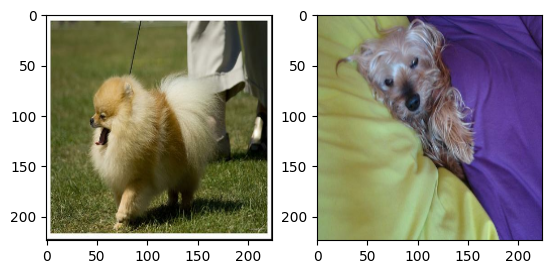

In [32]:
for i, (image, label) in enumerate(ds_train_1.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [33]:
label_a

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

#### 4) 훈련
각각의 모델을 훈련한다. 

#### resnet50_1 
- augmentation 없는 모델

In [34]:
resnet50_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_1 = resnet50_1.fit(
    ds_train_1, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

C:\Users\aeoli\anaconda3\envs\tensor_for_p397\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30
750/750 [==============================] - 86s 100ms/step - loss: 2.1937 - accuracy: 0.4502 - val_loss: 3.5095 - val_accuracy: 0.2028
Epoch 2/30
750/750 [==============================] - 76s 101ms/step - loss: 0.6981 - accuracy: 0.8055 - val_loss: 1.1209 - val_accuracy: 0.6758
Epoch 3/30
750/750 [==============================] - 78s 104ms/step - loss: 0.1936 - accuracy: 0.9642 - val_loss: 0.9452 - val_accuracy: 0.7249
Epoch 4/30
750/750 [==============================] - 78s 104ms/step - loss: 0.0531 - accuracy: 0.9964 - val_loss: 0.9070 - val_accuracy: 0.7345
Epoch 5/30
750/750 [==============================] - 83s 111ms/step - loss: 0.0648 - accuracy: 0.9938 - val_loss: 0.9487 - val_accuracy: 0.7275
Epoch 6/30
750/750 [==============================] - 81s 108ms/step - loss: 0.0204 - accuracy: 0.9990 - val_loss: 0.9156 - val_accuracy: 0.7390
Epoch 7/30
750/750 [==============================] - 78s 104ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.9279 - val_ac

In [35]:
df_resnet_50_1 = pd.DataFrame({
    'train_loss': history_resnet50_1.history['loss'],
    'train_acc': history_resnet50_1.history['accuracy'],
    'val_loss': history_resnet50_1.history['val_loss'],
    'val_acc': history_resnet50_1.history['val_accuracy']
    })
df_resnet_50_1.to_csv('./history/history_resnet_50_1.csv', index=False)

In [36]:
del resnet50_1
del history_resnet50_1
del df_resnet_50_1

#### resnet50_2_aug 
- 기본 이미지 augmentation만 진행한 모델

In [37]:
resnet50_2_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_2_aug = resnet50_2_aug.fit(
    ds_train_2_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 91s 111ms/step - loss: 2.2780 - accuracy: 0.4277 - val_loss: 2.6627 - val_accuracy: 0.3160
Epoch 2/30
750/750 [==============================] - 83s 111ms/step - loss: 1.0162 - accuracy: 0.7031 - val_loss: 1.2618 - val_accuracy: 0.6316
Epoch 3/30
750/750 [==============================] - 85s 113ms/step - loss: 0.5937 - accuracy: 0.8316 - val_loss: 1.0235 - val_accuracy: 0.6999
Epoch 4/30
750/750 [==============================] - 69s 92ms/step - loss: 0.3694 - accuracy: 0.9012 - val_loss: 1.1001 - val_accuracy: 0.6834
Epoch 5/30
750/750 [==============================] - 63s 84ms/step - loss: 0.2337 - accuracy: 0.9425 - val_loss: 1.0357 - val_accuracy: 0.7018
Epoch 6/30
750/750 [==============================] - 63s 84ms/step - loss: 0.1627 - accuracy: 0.9640 - val_loss: 1.0489 - val_accuracy: 0.7076
Epoch 7/30
750/750 [==============================] - 63s 84ms/step - loss: 0.1154 - accuracy: 0.9777 - val_loss: 1.0204 - val_accura

In [38]:
df_resnet_50_2 = pd.DataFrame({
    'train_loss': history_resnet50_2_aug.history['loss'],
    'train_acc': history_resnet50_2_aug.history['accuracy'],
    'val_loss': history_resnet50_2_aug.history['val_loss'],
    'val_acc': history_resnet50_2_aug.history['val_accuracy']
    })
df_resnet_50_2.to_csv('./history/history_resnet_50_2.csv', index=False)

In [39]:
del resnet50_2_aug
del history_resnet50_2_aug
del df_resnet_50_2

#### resnet50_3
- 일반 augmentation은 제외하고, cutmix와 mixup augmetation만 진행하는 모델을 훈련한다. 
- cutmix, mixup 각각 별개의 모델로 훈련한다. 

- cutmix augmentation 모델

In [40]:
resnet50_3_1_cut.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_3_1_cut = resnet50_3_1_cut.fit(
    ds_train_3_1_cut, # 기본 augmentation 적용X cutmix만 적용한데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 67s 83ms/step - loss: 3.8706 - accuracy: 0.2102 - val_loss: 3.3205 - val_accuracy: 0.2046
Epoch 2/30
750/750 [==============================] - 62s 83ms/step - loss: 2.9571 - accuracy: 0.4285 - val_loss: 1.4392 - val_accuracy: 0.6194
Epoch 3/30
750/750 [==============================] - 62s 83ms/step - loss: 2.6457 - accuracy: 0.5276 - val_loss: 1.2192 - val_accuracy: 0.6673
Epoch 4/30
750/750 [==============================] - 62s 83ms/step - loss: 2.4924 - accuracy: 0.5767 - val_loss: 1.1844 - val_accuracy: 0.6712
Epoch 5/30
750/750 [==============================] - 62s 83ms/step - loss: 2.3070 - accuracy: 0.6347 - val_loss: 1.1299 - val_accuracy: 0.6878
Epoch 6/30
750/750 [==============================] - 62s 83ms/step - loss: 2.2175 - accuracy: 0.6676 - val_loss: 1.1424 - val_accuracy: 0.6841
Epoch 7/30
750/750 [==============================] - 63s 83ms/step - loss: 2.0825 - accuracy: 0.7060 - val_loss: 1.1943 - val_accuracy:

In [41]:
df_resnet_50_3_1_cut = pd.DataFrame({
    'train_loss': history_resnet50_3_1_cut.history['loss'],
    'train_acc': history_resnet50_3_1_cut.history['accuracy'],
    'val_loss': history_resnet50_3_1_cut.history['val_loss'],
    'val_acc': history_resnet50_3_1_cut.history['val_accuracy']
    })
df_resnet_50_3_1_cut.to_csv('./history/history_resnet_50_3_1_cut.csv', index=False)

In [43]:
# del resnet50_3_1_cut
# del history_resnet50_3_1_cut
del df_resnet_50_3_1_cut

- mixup augmentation 모델

In [44]:
resnet50_3_2_mix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_3_2_mix = resnet50_3_2_mix.fit(
    ds_train_3_2_mix, # 기본 augmentation 적용X mixup만 적용한데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 65s 82ms/step - loss: 3.7396 - accuracy: 0.2423 - val_loss: 3.7097 - val_accuracy: 0.1550
Epoch 2/30
750/750 [==============================] - 62s 82ms/step - loss: 2.8713 - accuracy: 0.4771 - val_loss: 1.5615 - val_accuracy: 0.5625
Epoch 3/30
750/750 [==============================] - 62s 83ms/step - loss: 2.6172 - accuracy: 0.5649 - val_loss: 1.4456 - val_accuracy: 0.5939
Epoch 4/30
750/750 [==============================] - 62s 83ms/step - loss: 2.4338 - accuracy: 0.6334 - val_loss: 1.2798 - val_accuracy: 0.6426
Epoch 5/30
750/750 [==============================] - 62s 83ms/step - loss: 2.3099 - accuracy: 0.6875 - val_loss: 1.3018 - val_accuracy: 0.6452
Epoch 6/30
750/750 [==============================] - 62s 83ms/step - loss: 2.2057 - accuracy: 0.7283 - val_loss: 1.3118 - val_accuracy: 0.6388
Epoch 7/30
750/750 [==============================] - 63s 84ms/step - loss: 2.1118 - accuracy: 0.7609 - val_loss: 1.3534 - val_accuracy:

In [45]:
df_resnet50_3_2_mix = pd.DataFrame({
    'train_loss': history_resnet50_3_2_mix.history['loss'],
    'train_acc': history_resnet50_3_2_mix.history['accuracy'],
    'val_loss': history_resnet50_3_2_mix.history['val_loss'],
    'val_acc': history_resnet50_3_2_mix.history['val_accuracy']
    })
df_resnet50_3_2_mix.to_csv('./history/history_resnet50_3_2_mix.csv', index=False)

In [46]:
del resnet50_3_2_mix
del history_resnet50_3_2_mix
del df_resnet50_3_2_mix

#### resnet50_4
- 기본 augmentation과 cutmix와 mixup을 각각 적용한 모델을 훈련한다. 

- 기본 augmentation 및 cutmix적용 모델

In [47]:
resnet50_4_1_augcut.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_4_1_augcut = resnet50_4_1_augcut.fit(
    ds_train_4_1_augcut, # 기본 augmentation 적용O cutmix만 적용한데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 67s 84ms/step - loss: 3.8825 - accuracy: 0.1972 - val_loss: 3.6587 - val_accuracy: 0.1824
Epoch 2/30
750/750 [==============================] - 63s 83ms/step - loss: 3.0545 - accuracy: 0.4046 - val_loss: 1.7890 - val_accuracy: 0.5135
Epoch 3/30
750/750 [==============================] - 63s 84ms/step - loss: 2.7917 - accuracy: 0.4839 - val_loss: 1.3605 - val_accuracy: 0.6206
Epoch 4/30
750/750 [==============================] - 63s 83ms/step - loss: 2.6129 - accuracy: 0.5287 - val_loss: 1.2521 - val_accuracy: 0.6432
Epoch 5/30
750/750 [==============================] - 62s 83ms/step - loss: 2.4812 - accuracy: 0.5734 - val_loss: 1.2373 - val_accuracy: 0.6639
Epoch 6/30
750/750 [==============================] - 63s 84ms/step - loss: 2.3683 - accuracy: 0.6093 - val_loss: 1.3029 - val_accuracy: 0.6424
Epoch 7/30
750/750 [==============================] - 63s 84ms/step - loss: 2.2940 - accuracy: 0.6259 - val_loss: 1.1406 - val_accuracy:

In [48]:
df_resnet50_4_1_augcut = pd.DataFrame({
    'train_loss': history_resnet50_4_1_augcut.history['loss'],
    'train_acc': history_resnet50_4_1_augcut.history['accuracy'],
    'val_loss': history_resnet50_4_1_augcut.history['val_loss'],
    'val_acc': history_resnet50_4_1_augcut.history['val_accuracy']
    })
df_resnet50_4_1_augcut.to_csv('./history/history_resnet50_4_1_augcut.csv', index=False)

In [49]:
del resnet50_4_1_augcut
del history_resnet50_4_1_augcut
del df_resnet50_4_1_augcut

- 기본 augmentation 및 mixup적용 모델

In [50]:
resnet50_4_2_augmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_4_2_augmix = resnet50_4_2_augmix.fit(
    ds_train_4_2_augmix, # 기본 augmentation 적용O cutmix만 적용한데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - 68s 84ms/step - loss: 3.7428 - accuracy: 0.2285 - val_loss: 3.8241 - val_accuracy: 0.1385
Epoch 2/30
750/750 [==============================] - 63s 83ms/step - loss: 2.9481 - accuracy: 0.4417 - val_loss: 1.4215 - val_accuracy: 0.6039
Epoch 3/30
750/750 [==============================] - 63s 84ms/step - loss: 2.6914 - accuracy: 0.5397 - val_loss: 1.4326 - val_accuracy: 0.5915
Epoch 4/30
750/750 [==============================] - 63s 84ms/step - loss: 2.5393 - accuracy: 0.5939 - val_loss: 1.3436 - val_accuracy: 0.6222
Epoch 5/30
750/750 [==============================] - 63s 84ms/step - loss: 2.4099 - accuracy: 0.6403 - val_loss: 1.2941 - val_accuracy: 0.6440
Epoch 6/30
750/750 [==============================] - 63s 84ms/step - loss: 2.3005 - accuracy: 0.6824 - val_loss: 1.3195 - val_accuracy: 0.6327
Epoch 7/30
750/750 [==============================] - 63s 84ms/step - loss: 2.2528 - accuracy: 0.7003 - val_loss: 1.3865 - val_accuracy:

In [51]:
df_resnet50_4_2_augmix = pd.DataFrame({
    'train_loss': history_resnet50_4_2_augmix.history['loss'],
    'train_acc': history_resnet50_4_2_augmix.history['accuracy'],
    'val_loss': history_resnet50_4_2_augmix.history['val_loss'],
    'val_acc': history_resnet50_4_2_augmix.history['val_accuracy']
    })
df_resnet50_4_2_augmix.to_csv('./history/history_resnet50_4_2_augmix.csv', index=False)

In [52]:
del resnet50_4_2_augmix
del history_resnet50_4_2_augmix
del df_resnet50_4_2_augmix

### 4. 훈련 과정 시각화하기
----
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

In [3]:
df_resnet50_1 = pd.read_csv('./history/history_resnet_50_1.csv')
df_resnet50_2_aug = pd.read_csv('./history/history_resnet_50_2.csv')
df_resnet50_3_1_cut = pd.read_csv('./history/history_resnet_50_3_1_cut.csv')
df_resnet50_3_2_mix = pd.read_csv('./history/history_resnet50_3_2_mix.csv')
df_resnet50_4_1_augcut = pd.read_csv('./history/history_resnet50_4_1_augcut.csv')
df_resnet50_4_2_augmix = pd.read_csv('./history/history_resnet50_4_2_augmix.csv')

#### augmentation없는 데이터 훈련 결과

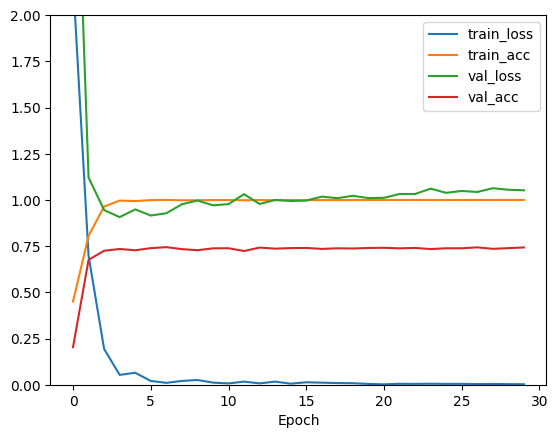

In [17]:
plt.plot(df_resnet50_1['train_loss'], label='train_loss')
plt.plot(df_resnet50_1['train_acc'], label='train_acc')
plt.plot(df_resnet50_1['val_loss'], label='val_loss')
plt.plot(df_resnet50_1['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

#### 기본 augmentation 학습결과

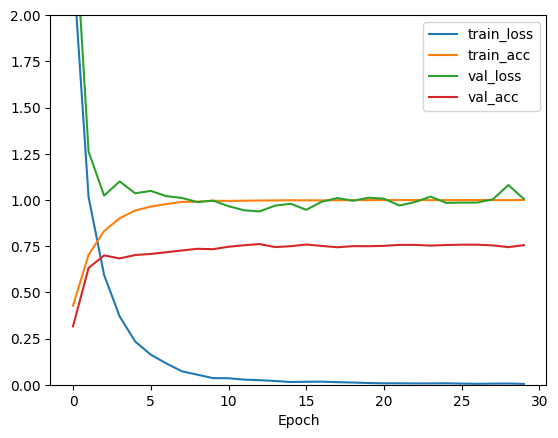

In [18]:
plt.plot(df_resnet50_2_aug['train_loss'], label='train_loss')
plt.plot(df_resnet50_2_aug['train_acc'], label='train_acc')
plt.plot(df_resnet50_2_aug['val_loss'], label='val_loss')
plt.plot(df_resnet50_2_aug['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

#### 기본 augmentation없이 cutmix만 적용한 결과

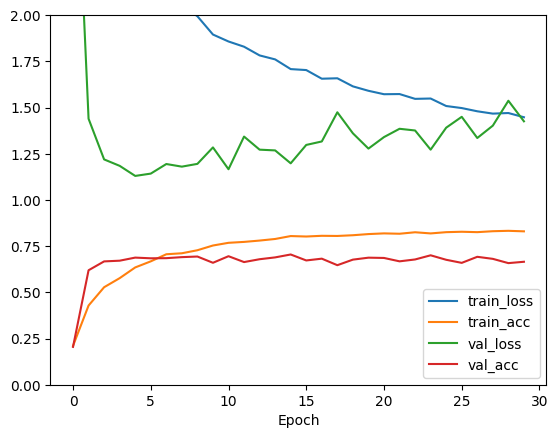

In [16]:
plt.plot(df_resnet50_3_1_cut['train_loss'], label='train_loss')
plt.plot(df_resnet50_3_1_cut['train_acc'], label='train_acc')
plt.plot(df_resnet50_3_1_cut['val_loss'], label='val_loss')
plt.plot(df_resnet50_3_1_cut['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

#### 기본 augmentation없이 mixup만 적용한 결과

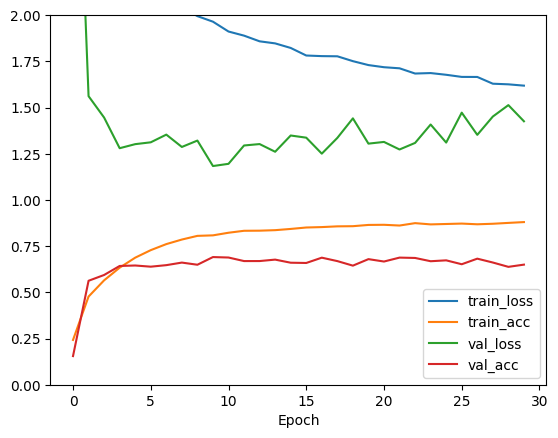

In [19]:
plt.plot(df_resnet50_3_2_mix['train_loss'], label='train_loss')
plt.plot(df_resnet50_3_2_mix['train_acc'], label='train_acc')
plt.plot(df_resnet50_3_2_mix['val_loss'], label='val_loss')
plt.plot(df_resnet50_3_2_mix['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

#### 기본 augmentation과 cutmix둘 다 적용한 결과

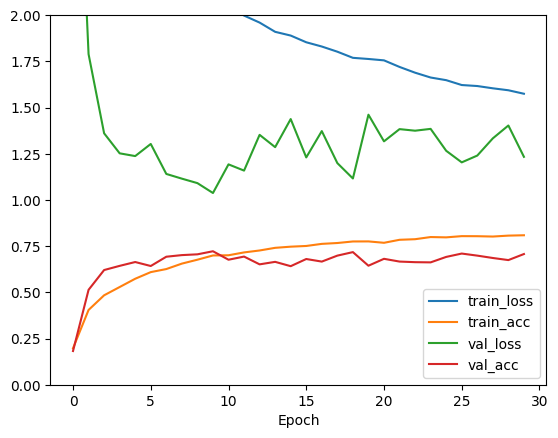

In [20]:
plt.plot(df_resnet50_4_1_augcut['train_loss'], label='train_loss')
plt.plot(df_resnet50_4_1_augcut['train_acc'], label='train_acc')
plt.plot(df_resnet50_4_1_augcut['val_loss'], label='val_loss')
plt.plot(df_resnet50_4_1_augcut['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

#### 기본 augmentation과 mixup둘 다 적용한 결과

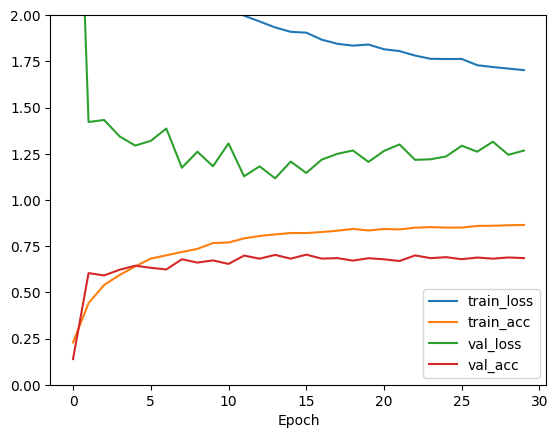

In [21]:
plt.plot(df_resnet50_4_2_augmix['train_loss'], label='train_loss')
plt.plot(df_resnet50_4_2_augmix['train_acc'], label='train_acc')
plt.plot(df_resnet50_4_2_augmix['val_loss'], label='val_loss')
plt.plot(df_resnet50_4_2_augmix['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0, 2.0)

plt.show()

### 소결론
1. 현재 실험결과로만 놓고 보면 augmentation이 뚜렷한 성능의 향상을 가져오지는 않는다. 
2. 플립과 랜덤브라이트니스를 적용한 데이터를 훈련한 모델이 가장 성능이 좋았다. 
3. 다만 이는 데이터의 양을 늘리지 않고, 같은 데이터 수량 안에서 augmentation만 진행한 결과이니 감안해야 한다. 
4. cutmix나 mixup은 훈련 난이도를 상당히 향상시키고 있음을 확인 할수 있다. 
    - 다만 본 실험에서는 오버피팅 경향이 비교적 빠르게 나타나는 것에 대해 고민해볼 필요가 있어보인다. 

### 5. Augmentation에 의한 모델 성능 비교
----
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

#### 1) 각 모델별 validation data accuracy 비교

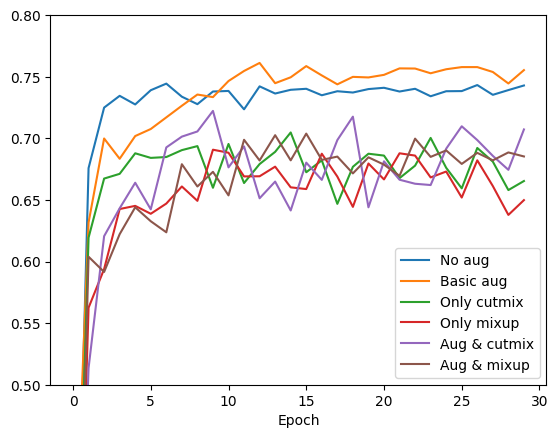

In [25]:
plt.plot(df_resnet50_1['val_acc'], label='No aug')
plt.plot(df_resnet50_2_aug['val_acc'], label='Basic aug')
plt.plot(df_resnet50_3_1_cut['val_acc'], label='Only cutmix')
plt.plot(df_resnet50_3_2_mix['val_acc'], label='Only mixup')
plt.plot(df_resnet50_4_1_augcut['val_acc'], label='Aug & cutmix')
plt.plot(df_resnet50_4_2_augmix['val_acc'], label='Aug & mixup')

plt.xlabel('Epoch')
plt.legend()
plt.ylim(0.5, 0.8)

plt.show()

#### 2) 각 모델별 validation data loss 비교

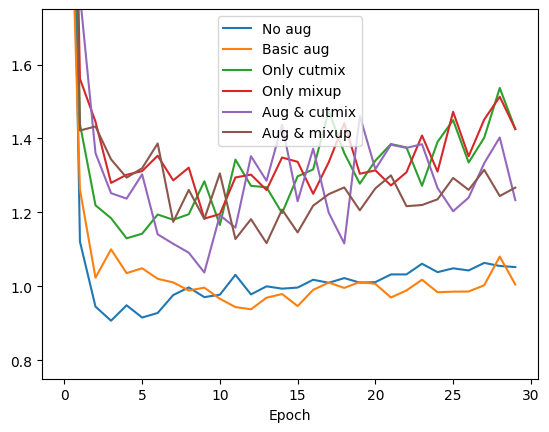

In [28]:
plt.plot(df_resnet50_1['val_loss'], label='No aug')
plt.plot(df_resnet50_2_aug['val_loss'], label='Basic aug')
plt.plot(df_resnet50_3_1_cut['val_loss'], label='Only cutmix')
plt.plot(df_resnet50_3_2_mix['val_loss'], label='Only mixup')
plt.plot(df_resnet50_4_1_augcut['val_loss'], label='Aug & cutmix')
plt.plot(df_resnet50_4_2_augmix['val_loss'], label='Aug & mixup')

plt.xlabel('Epoch')
plt.legend()
plt.ylim(0.75, 1.75)

plt.show()

#### 3) 각 모델별 train loss와 validation data loss 비교

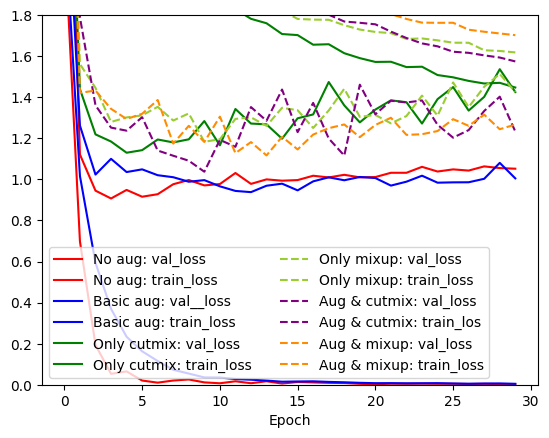

In [48]:
plt.plot(df_resnet50_1['val_loss'], 'r', label='No aug: val_loss')
plt.plot(df_resnet50_1['train_loss'], 'r', label='No aug: train_loss')
plt.plot(df_resnet50_2_aug['val_loss'], 'b', label='Basic aug: val__loss')
plt.plot(df_resnet50_2_aug['train_loss'], 'b', label='Basic aug: train_loss')
plt.plot(df_resnet50_3_1_cut['val_loss'], 'g', label='Only cutmix: val_loss')
plt.plot(df_resnet50_3_1_cut['train_loss'], 'g', label='Only cutmix: train_loss')
plt.plot(df_resnet50_3_2_mix['val_loss'], linestyle='dashed', color='yellowgreen', label='Only mixup: val_loss')
plt.plot(df_resnet50_3_2_mix['train_loss'], linestyle='dashed', color='yellowgreen', label='Only mixup: train_loss')
plt.plot(df_resnet50_4_1_augcut['val_loss'], linestyle='dashed', color='purple', label='Aug & cutmix: val_loss')
plt.plot(df_resnet50_4_1_augcut['train_loss'], linestyle='dashed', color='purple', label='Aug & cutmix: train_los')
plt.plot(df_resnet50_4_2_augmix['val_loss'], linestyle='dashed', color='darkorange', label='Aug & mixup: val_loss')
plt.plot(df_resnet50_4_2_augmix['train_loss'], linestyle='dashed', color='darkorange', label='Aug & mixup: train_loss')

plt.xlabel('Epoch')
plt.legend(ncol=2)
plt.ylim(0, 1.8)

plt.show()

### 소결론
1. 모델별 성능에서는 기본 augmentation을 진행한 모델이 가장 높은 성능을 기록했다. 
2. cutmix나 mixup의경우 validation loss보다 train loss가 늦게 떨어지고 있다. 이는 augmentation에 의한 훈련 난이도 상승을 유추해볼 수 있다. (validation data에는 cutmix나 mixup이 적용되지 않았기 때문)
3. train loss가 충분히 떨어지지 않았을 때 validation loss가 상승하는 경향을 보인다면 그것을 오버피팅이 일어나고 있다고 봐도 되는건지 궁금하다. 

# 회고

### 신경쓴점
- 최대한 다양한 data augmentation 기법이 적용된 dataset으로 실험해보려 노력했다. 
- local 환경에서 잘 돌아가도록 ram과 vram 사용에 신경썼다. 
- 시각화를 보기 쉽게 그릴수 있도록 노력했다. 
- 다양한 환경의 augmentation의 훈련결과를 비교했다. 

### 아쉬운점
- 각 데이터셋 별로 다양한 하이퍼파리미터 튜닝을 시도해보지 못했다. 
- adam보다 SGD가 훈련이 잘되었는데 그 원인을 찾지 못했다. 
- cutmix나 mixup보다 일반 augmentation 훈련결과가 더 좋은데 이에 대한 해결책을 찾지 못했다. 

### 개선하고 싶은점
- 다양한 하이퍼파라미터 튜닝을 시도해보고 싶다. 
- epoch을 100단위대로 늘려보고 싶다. 
- data의 양을 늘리는 augmentation을 시도하고, 그 환경에서 cutmix와 mixup의 성능을 확인해보고 싶다. 

### reference
- LMS
- 앤드류 융